# How Exactly UMAP Works

In this lab we will:

* program UMAP from scratch in Python
* Answer some questions

### Table of Contents:

* [Why UMAP Can Preserve Global Structure](#Why-UMAP-Can-Preserve-Global-Structure)
* [Open Questions to UMAP](#Open-Questions-to-UMAP)

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances
 
from sklearn.metrics import pairwise_distances

path = ''
expr = pd.read_csv(path + 'bartoschek_filtered_expr_rpkm.txt', sep='\t')
print(expr.iloc[0:4,0:4])
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train+1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

This data set contains 716 samples

Dimensions of the  data set: 
(716, 557) (716,)


In the next step you need to compute the pairwise Euclidean distances between samples in your dataset and then find a specific value related to these distances for each sample `rho`.

In [18]:
# computes the pairwise square Euclidean distances between all samples in X_train.
dist = pairwise_distances(X_train)
#For each sample, sort its distances to all other samples. and then using the second-smallest distance as the rho
rho = np.sort(dist, axis=1)[:, 1]
print(dist[0:4, 0:4])
print('\n')
print(rho[0:4])

[[ 0.         30.24814313 38.43785063 55.10818199]
 [30.24814313  0.         36.15788913 54.40970134]
 [38.43785063 36.15788913  0.         51.75272385]
 [55.10818199 54.40970134 51.75272385  0.        ]]


[28.37686481 25.542167   32.20094959 35.28283403]


In [19]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions 
    (basically the function that given a sigma and a sample will return a distribtion
    for how close a sample is to the rest of the samples)
    """
    d = dist[dist_row] - rho[dist_row]
    d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    (This one will return the sum of of the distruibtuion)
    """
    return np.power(2, np.sum(prob))

def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    (this one will hypertunr the value of sigma for a given array of distances and the number of neighbors)
    """
    
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        #fine the new value of sigma after one BS itiration
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        # check if the number of neighbors is less the wanted value
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

N_NEIGHBOR = 15
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    # add the the new distribution using the new sigma
    prob[dist_row, :] = prob_high_dim(binary_search_result, dist_row)
    # add the new sigma to the sigma list 
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 716 cells
Sigma binary search finished 200 of 716 cells
Sigma binary search finished 300 of 716 cells
Sigma binary search finished 400 of 716 cells
Sigma binary search finished 500 of 716 cells
Sigma binary search finished 600 of 716 cells
Sigma binary search finished 700 of 716 cells

Mean sigma = 0.9164170845926807


In [20]:
# Now you need to make the array prob symmetric by averaging it's value with its inverse
prob = (prob + prob.T) / 2
P = prob / np.sum(prob, axis=1, keepdims=True)

# why do think that we need this? 

In [21]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.121436342630349 and b = 1.0574998767512587


In [22]:
a = 1.121436342246895
b = 1.0574998767516528

In [23]:
def prob_low_dim(Y):
    """
    create and compute matrix of probabilities q_ij in low-dimensional space
    """
    distance_sample_wise = ...
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = prob_low_dim(Y)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a * P * (1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [24]:
import os

os.makedirs('UMAP_Plots', exist_ok=True)

N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 200

np.random.seed(42)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    # Move the new data (y) by taking a grading step using cross entropy between the two representaions of the datasets
    # also we need to adjust the gradient step according to the learning rate
    gradient = CE_gradient(P, y)
    y -= LEARNING_RATE * gradient
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    plt.savefig('UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()

    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

Running Gradient Descent: 

Cross-Entropy = 2.103862416900584 after 0 iterations
Cross-Entropy = 0.9925650532197456 after 10 iterations
Cross-Entropy = 0.7217257167061935 after 20 iterations
Cross-Entropy = 0.6262200992668994 after 30 iterations
Cross-Entropy = 0.6178175624620736 after 40 iterations
Cross-Entropy = 0.6746278012361235 after 50 iterations
Cross-Entropy = 0.719587648311255 after 60 iterations
Cross-Entropy = 0.7178330904480797 after 70 iterations
Cross-Entropy = 0.7318983108419912 after 80 iterations
Cross-Entropy = 0.7498449748499237 after 90 iterations
Cross-Entropy = 0.7527898974449058 after 100 iterations
Cross-Entropy = 0.7418566121605349 after 110 iterations
Cross-Entropy = 0.7331424176965295 after 120 iterations
Cross-Entropy = 0.726394860127805 after 130 iterations
Cross-Entropy = 0.7208701732644132 after 140 iterations
Cross-Entropy = 0.7226347566787443 after 150 iterations
Cross-Entropy = 0.7276045488690076 after 160 iterations
Cross-Entropy = 0.7494862436710656

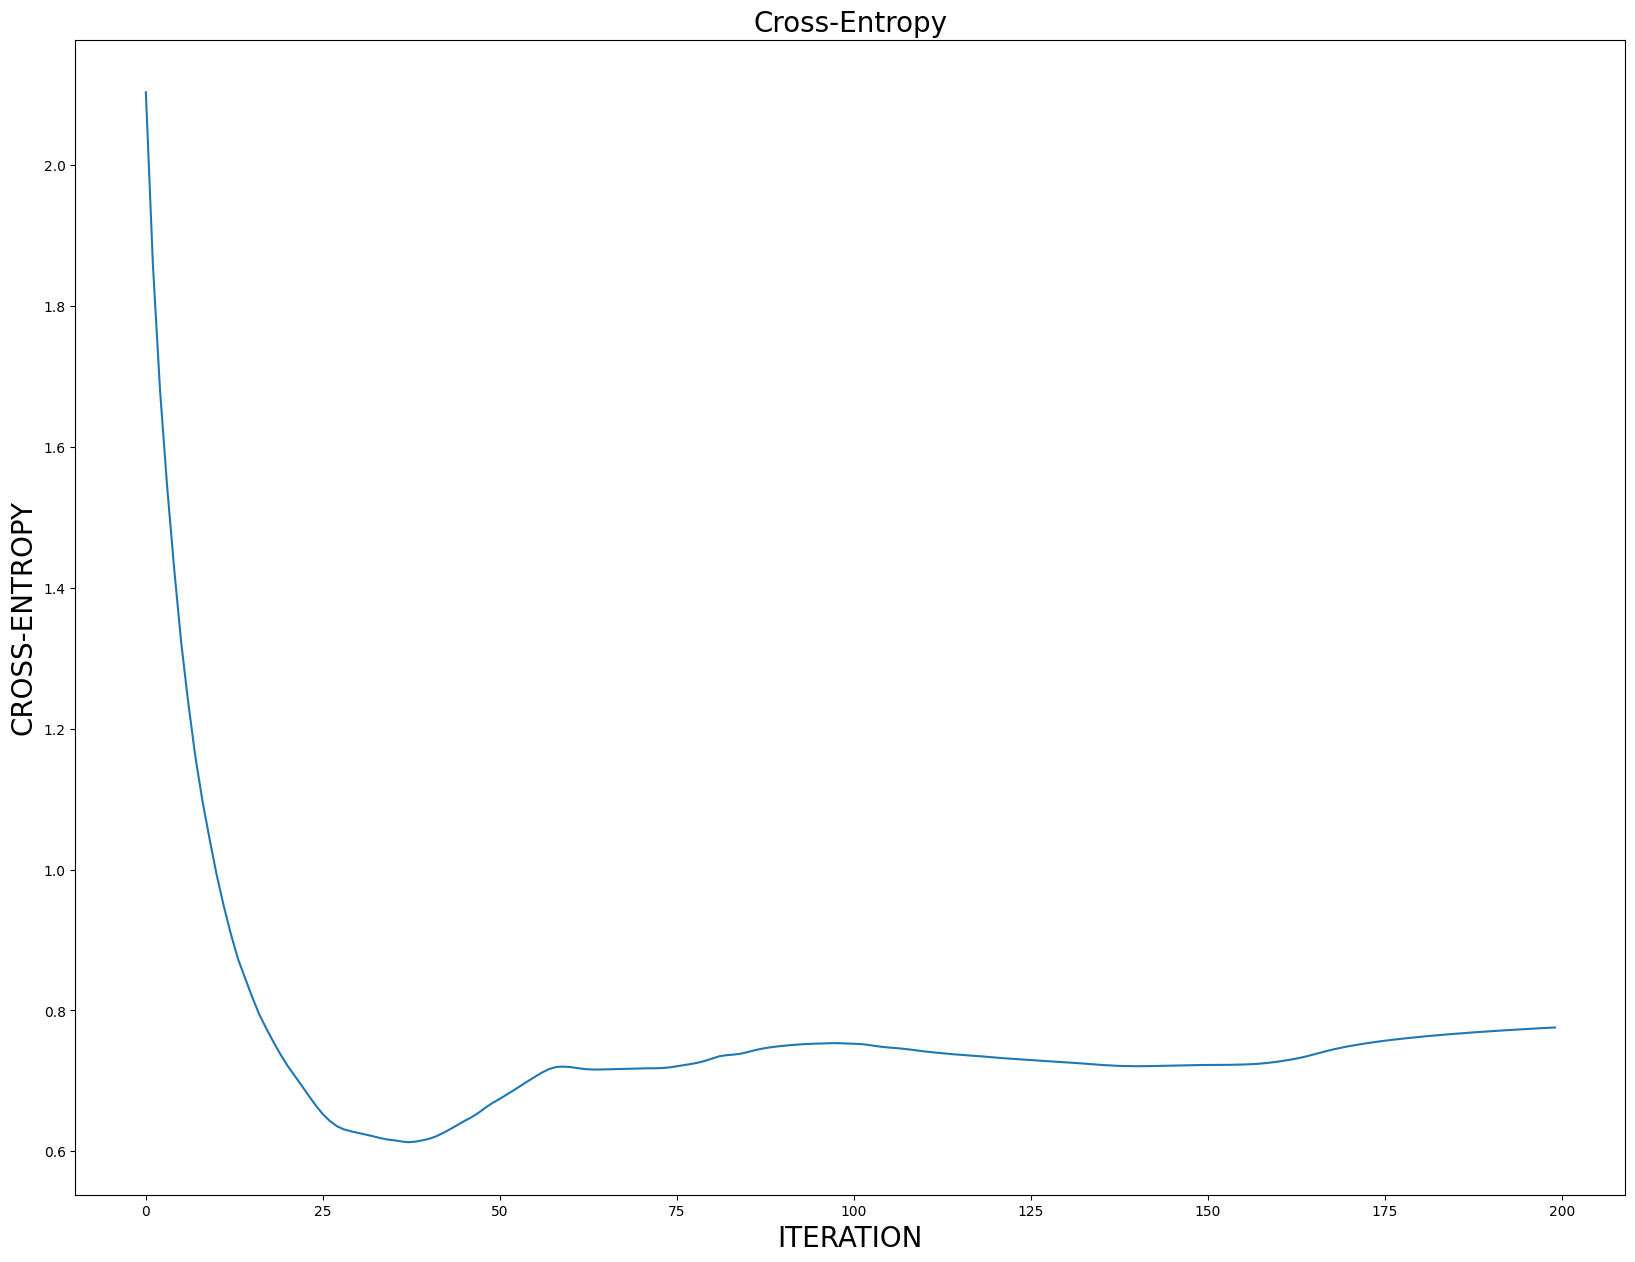

In [25]:
plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

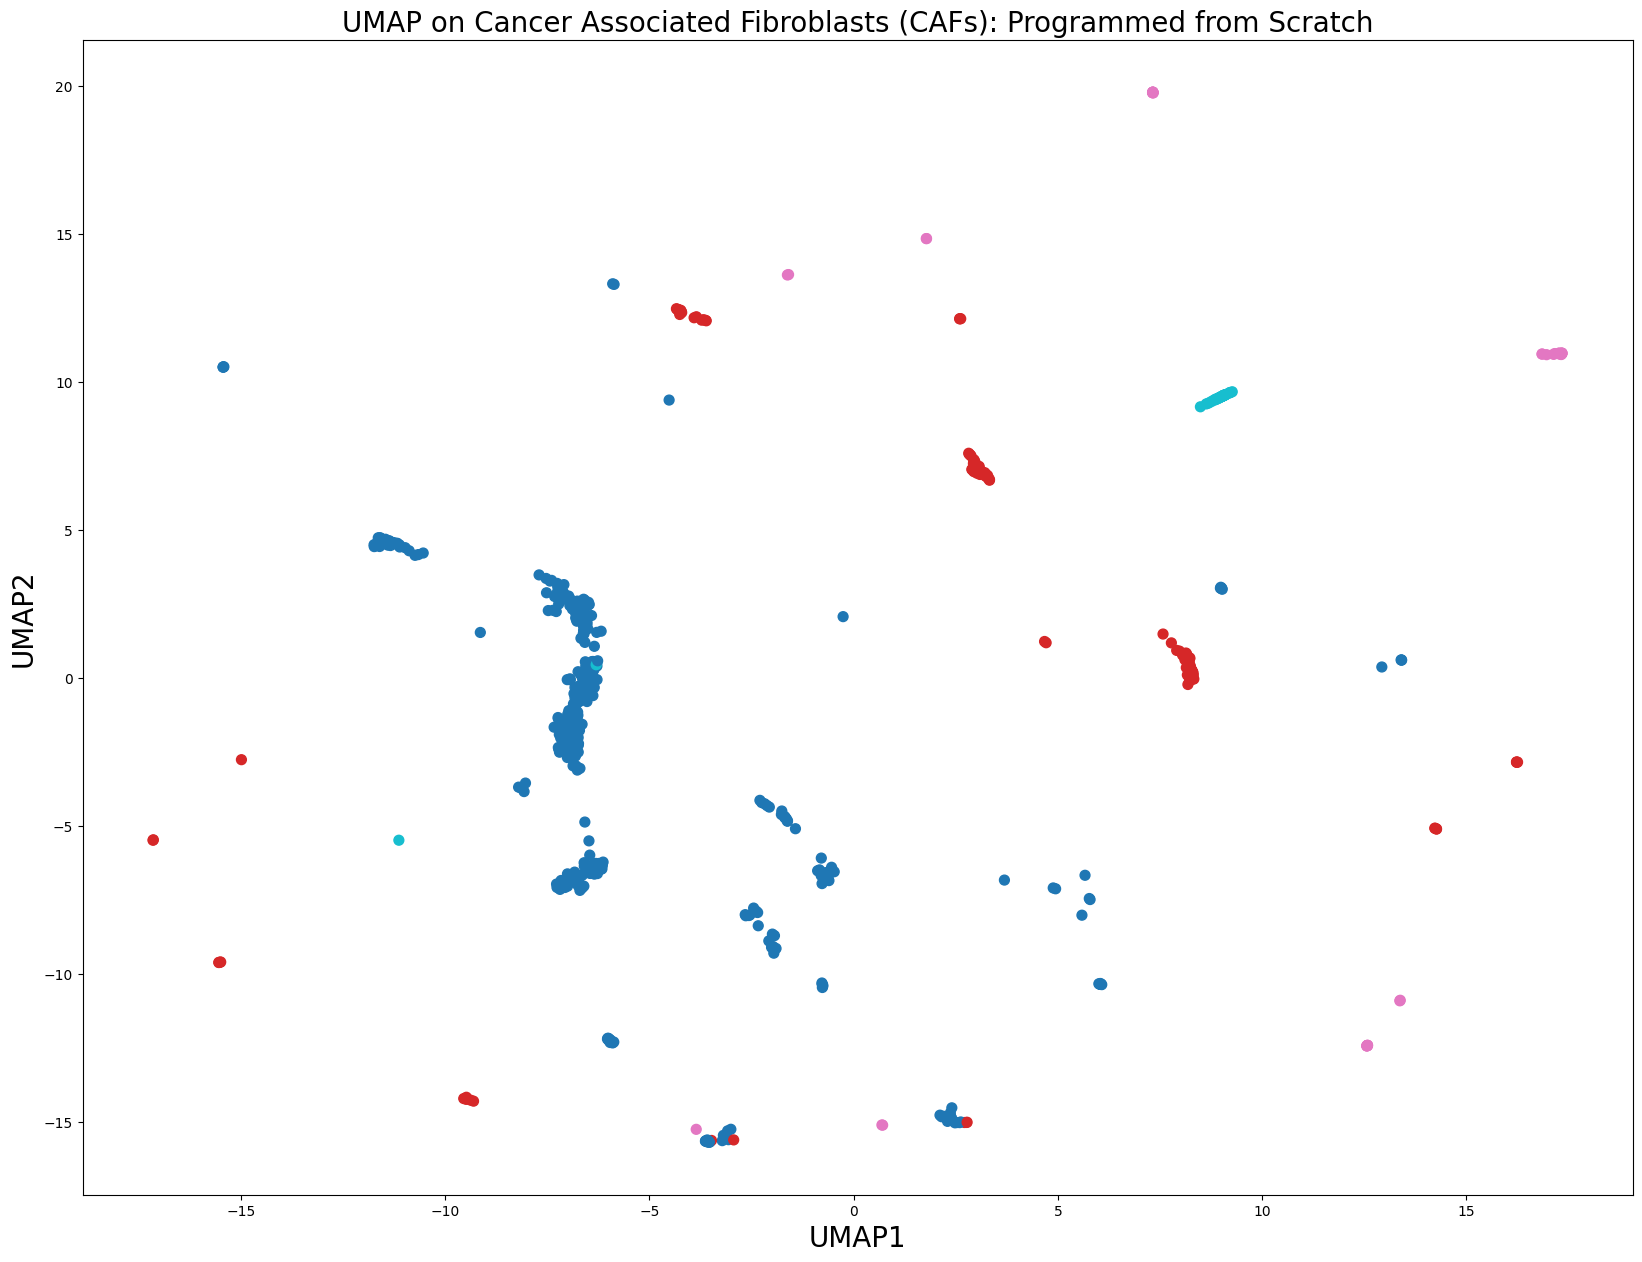

In [26]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()

We can see distinct and tight clusters similar to what it looks like at a UMAP plot. Moreover, these cell populations are super-easy to cluster now with any cluster algorithm, perferably graph-based or density-based, however even K-means or Gaussian Mixture Model (GMM) would do a good job on such a clear dimension reduction plot. Let us animate the clustering process in order to see how the points groups into the clusters:

In [27]:
! pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 4.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 7.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.2
    Uninstalling numpy-2.2.2:
      Successfully uninstalled numpy-2.2.2


In [29]:
import os
from PIL import Image
import imageio

def create_animation(image_folder, output_path, duration=0.5):
    """
    Create a GIF animation from all images in a specified folder.

    :param image_folder: Path to the folder containing images.
    :param output_path: Path where the GIF should be saved.
    :param duration: Duration of each frame in the animation (in seconds).
    """
    # Get all image file paths
    images = [img for img in os.listdir(image_folder) if img.endswith((".png", ".jpg", ".jpeg"))]
    images.sort()  # Sort the images by name

    # Create a list to hold the image objects
    frames = []
    for image in images:
        img_path = os.path.join(image_folder, image)
        new_frame = Image.open(img_path)
        frames.append(new_frame)

    # Save frames as a gif
    frames[0].save(output_path, format='GIF', append_images=frames[1:], save_all=True, duration=duration*1000, loop=0)

# Usage example
image_folder = "UMAP_Plots"
output_gif = 'UMAP_Plots/UMAP_animated.gif.png'
create_animation(image_folder, output_gif, duration=0.1)


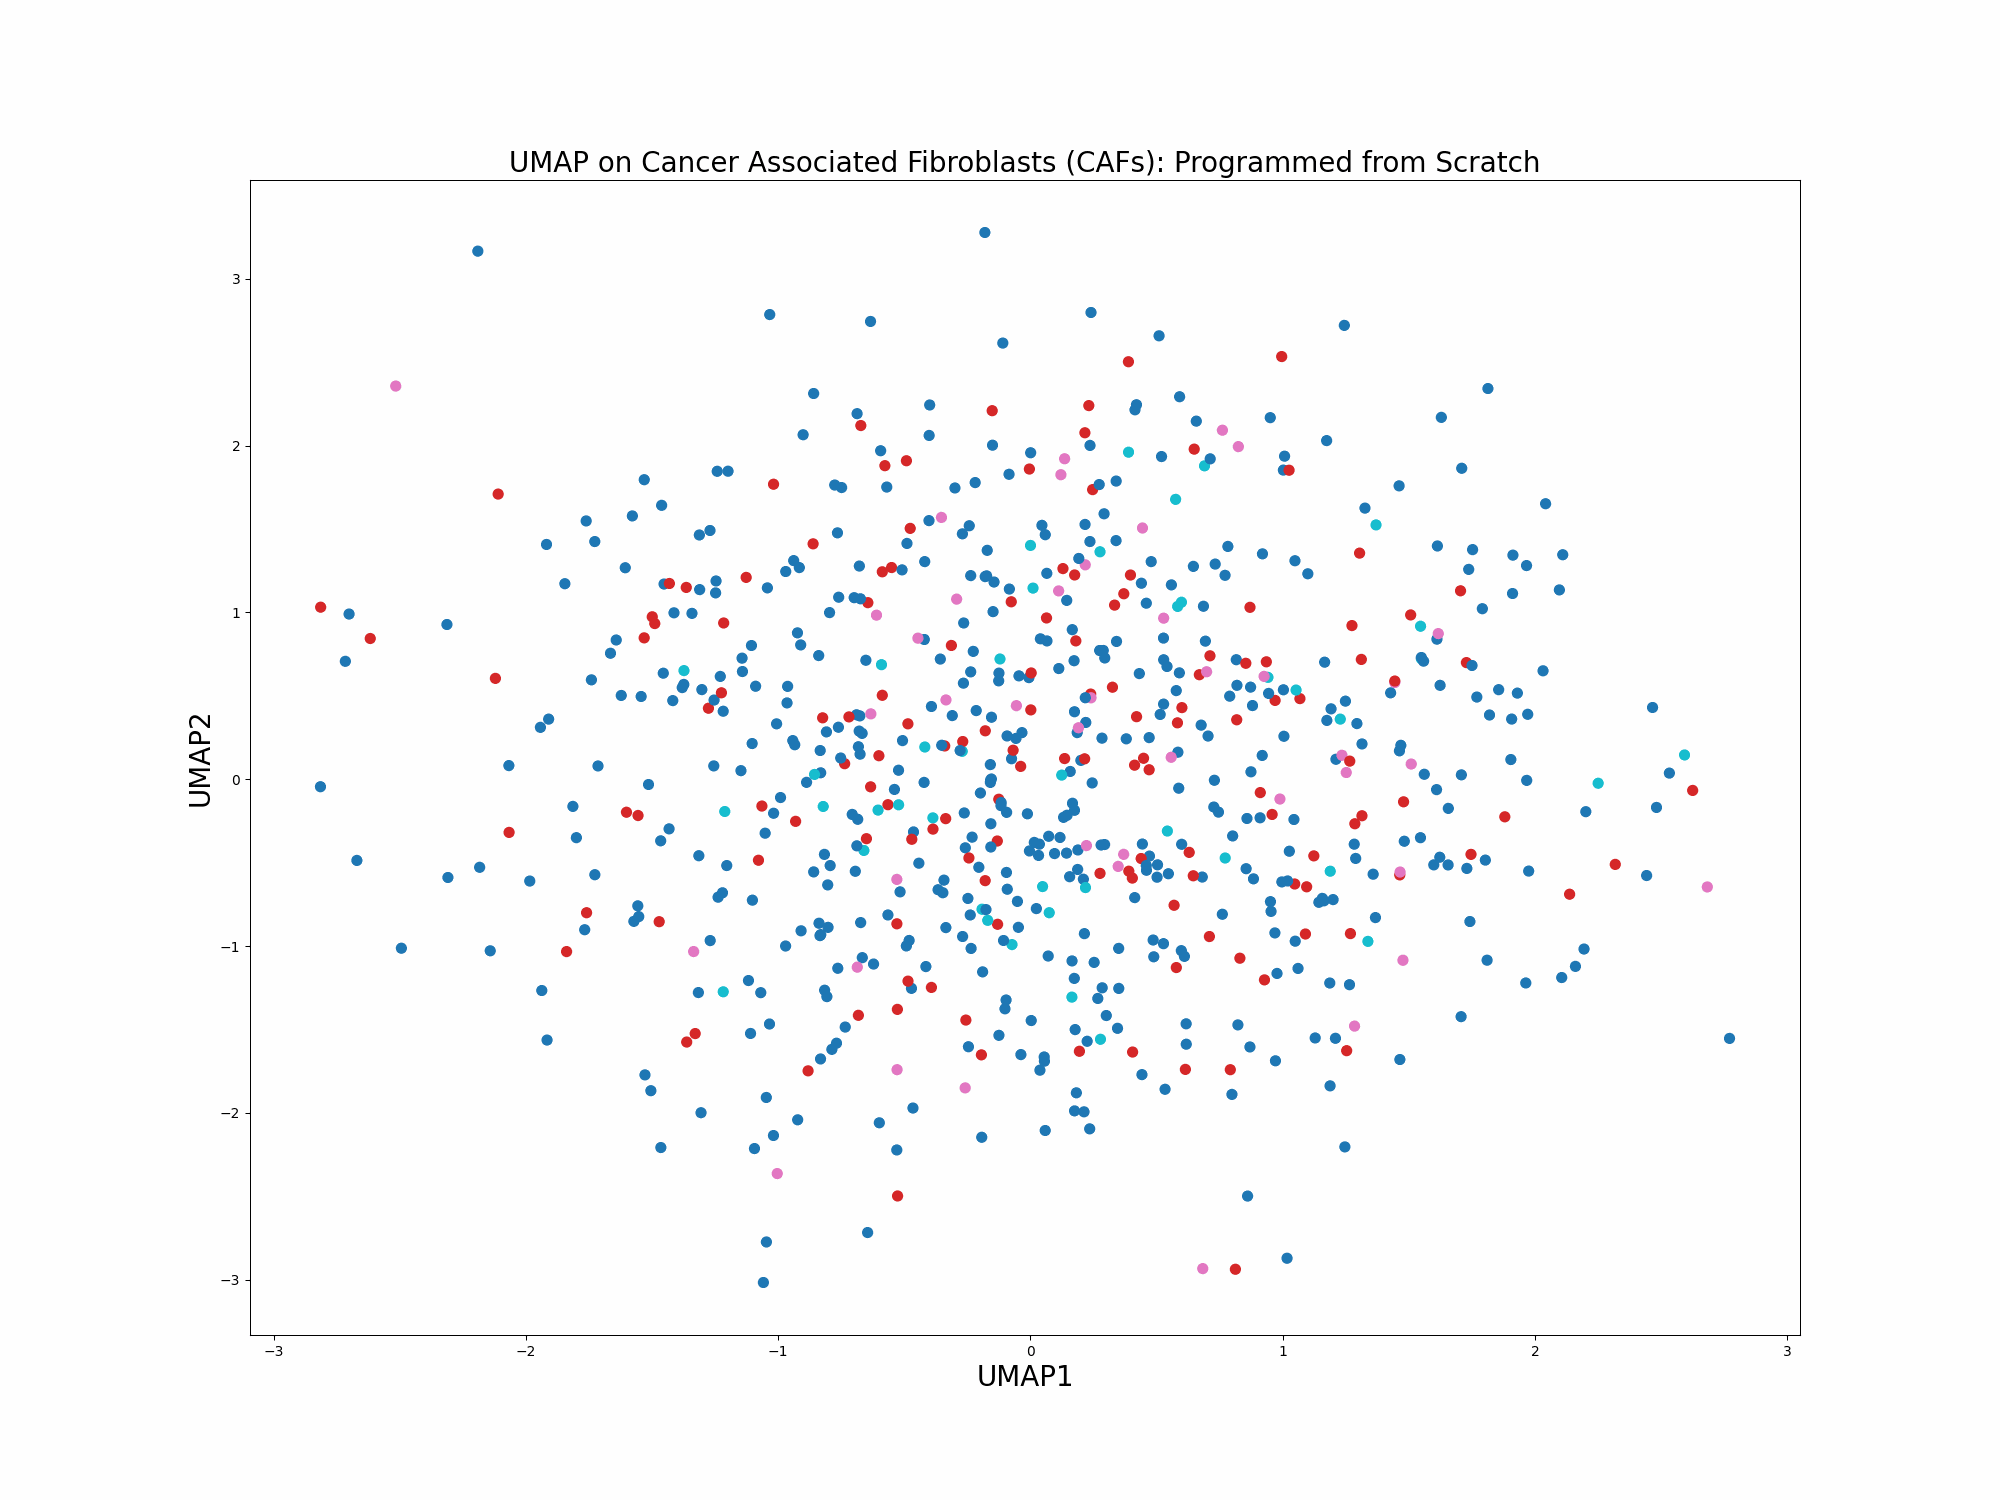

In [30]:
from IPython.display import Image
Image('UMAP_Plots/UMAP_animated.gif.png', width=2000)

For comparison let us use the original Leland McInnes Python implementation of UMAP with identical hyperparameters in oder to compare it with our "from scratch" UMAP implementation:

In [33]:
%pip install numpy==2.1

Note: you may need to restart the kernel to use updated packages.


/Users/maxmartyshov/Desktop/IU/year3/sem2/XAI/XAI-labs/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/maxmartyshov/Desktop/IU/year3/sem2/XAI/XAI-labs/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(min_dist=0.25, verbose=True)
Wed Jan 29 15:10:52 2025 Construct fuzzy simplicial set
Wed Jan 29 15:10:52 2025 Finding Nearest Neighbors
Wed Jan 29 15:10:55 2025 Finished Nearest Neighbor Search
Wed Jan 29 15:10:56 2025 Construct embedding


Epochs completed:  92%| █████████▏ 459/500 [00:01]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:01]


Wed Jan 29 15:10:57 2025 Finished embedding


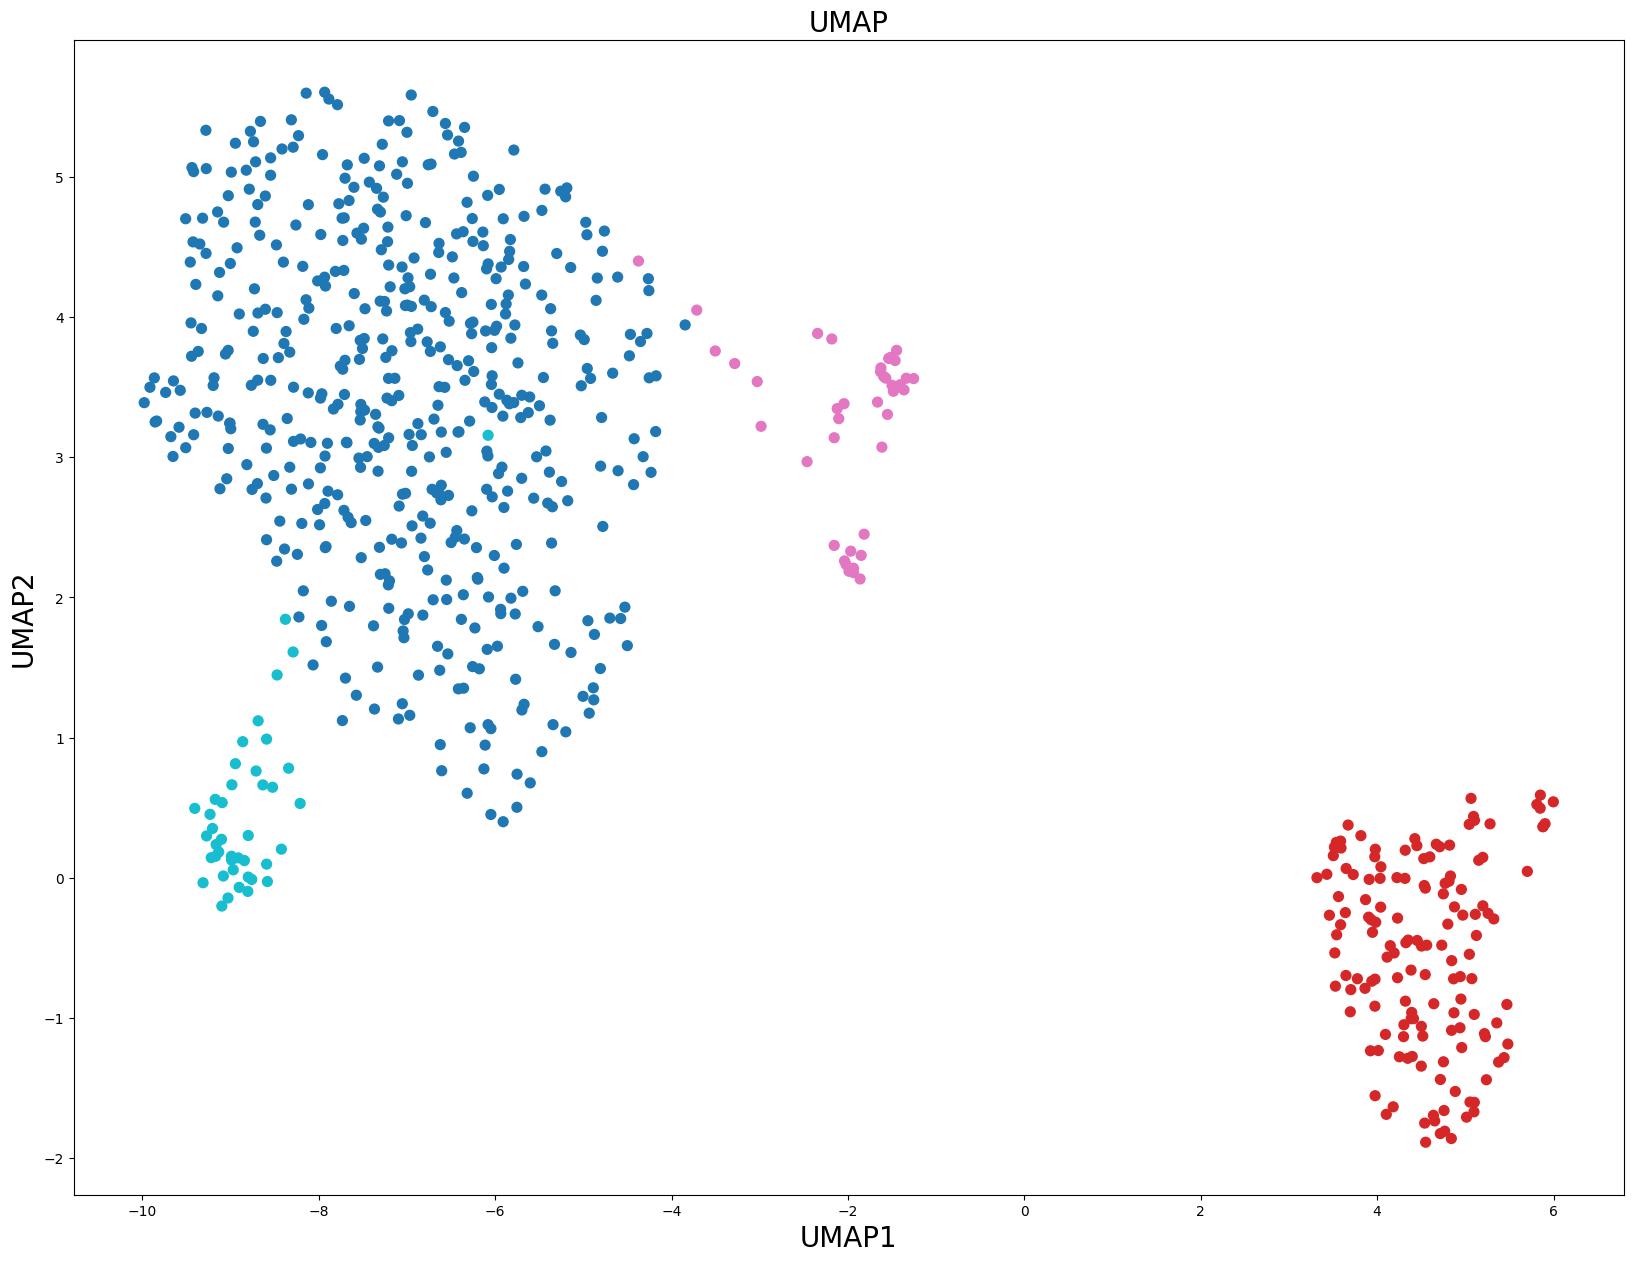

In [2]:
from umap.umap_ import UMAP

plt.figure(figsize=(20,15))
model = UMAP(n_neighbors=15, min_dist=0.25, n_components=2, verbose=True)
umap = model.fit_transform(X_train)
plt.scatter(umap[:, 0], umap[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()

We conclude that the original UMAP implementation from Leland McInnes looks quite similar to our "from scratch" implementation. In a sense, the clusters in our dimension reduction look even more distinct. This slight "otperformance" of original UMAP was achieved by setting **a = 1** and **b = 1** like for Student t-distribution and **using the tSNE symmetrization, Eq. (1),** and not the symmetrization with the Hadamard product from the UMAP algorithm.

My prediction is that UMAP is just the beginning, **in the future there will be more and better dimension reduction techniques** because it is quite straightforward to tune low/high dimensional distributions, make better normalizations, better cost functions and play with attractive/repulsive forces for the N-body problem in order to get even better low-dimensional representations. I expect to have an avelanche of such techniques for the Single Cell research area because **even I can improve UMAP low-dimensional representation making small modifications**. If I can do it, many people should be able to doit, so there are more dimensions reduction techniques to come.

### Open Questions to UMAP <a class="anchor" id="Open-Questions-to-UMAP"></a>

* what do you think about using UMAP for (categorical + continuous)? 
* Using UMAP on mixed data types (categorical + continuous) is not really shown, not fully clear how to do it. However, intuitively it seems like making non-parametric (rank) representation of the data via graphs can lead to possibility to merge the graphs and therefore integrate different types of data.

* What do you think about UMAP being used for new data after training?
* Since UMAP similarly to tSNE does not learn an explicit function of transforming from high- to low-dimensions, I do not understand how previous embeddings can be used to incorporate new unseen samples.